<a href="https://colab.research.google.com/github/pepperamy/tenK/blob/master/10k_featureselection_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold

In [ ]:
from keras import regularizers

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [ ]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, RNN,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import models
from keras import layers

In [ ]:
from sklearn.utils import class_weight

In [ ]:
from sklearn import utils

In [ ]:
import random

In [ ]:
df = pd.read_csv('data_performance_words_win1_comb_20210301.csv')

In [ ]:
df.shape

(53635, 212)

In [ ]:
sum(df.label)

487.0

In [ ]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u,WeakModal_up,WeakModal_down,Litigious_up,Litigious_down,StrongModal_up,StrongModal_down,Negative_up,Negative_down,Positive_up,Positive_down,Uncertainty_up,Uncertainty_down,Compare_up,Compare_down,Achieve_up,Achieve_down,Discrep_up,Discrep_down,Reward_up,Reward_down
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429,0.052570,0.095238,0.142857,0.193277,0.047619,0.058512,0.353070,0.338308,0.238095,0.292404,0.100189,0.145658,0.395804,0.355975,0.060777,0.303224,0.190476,0.248916,0.190476,0.193121
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000,0.028571,0.066667,0.200000,0.133333,0.161905,0.066667,0.161905,0.357243,0.200000,0.219242,0.123810,0.134598,0.333333,0.144428,0.133333,0.075494,0.133333,0.070482,0.200000,0.207947
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333,0.141174,0.072381,0.137649,0.137333,0.074024,0.139048,0.149893,0.299598,0.070786,0.271178,0.154181,0.144762,0.484144,0.236060,0.074921,0.277778,0.076624,0.202532,0.002960,0.268170
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455,0.136364,0.052210,0.045455,0.096370,0.048976,0.140434,0.093257,0.110468,0.045455,0.050488,0.187374,0.063963,0.195518,0.159758,0.101197,0.055574,0.103194,0.144520,0.053633,0.003575
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.176471,0.647059,-0.001826,0.011784,0.117647,0.054348,0.058824,0.

In [ ]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [ ]:
df_fl.label.value_counts()

0.0    53148
1.0      487
Name: label, dtype: int64

In [ ]:
df_fl.shape

(53635, 212)

In [ ]:
selected_new = ['WeakModal', 'Litigious', 'StrongModal','Negative', 'Positive', 'Uncertainty', 
        'Compare', 'Achieve', 'Discrep', 'Reward']

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [ ]:
selected_comb = []
for s in selected_new:
  selected_comb.append(s+'_up')
  selected_comb.append(s+'_down')

In [ ]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [ ]:
# df_fl_1 = df_fl.copy()
# df_fl_1.loc[:,selected_new_all] = df_fl_1.loc[:,selected_new_all]*10
# df_fl_1.loc[:,selected_new_all] = df_fl_1.loc[:,selected_new_all] **1.5

In [ ]:
#df_fl.loc[:,selected_new_all].describe()

In [ ]:
#df_fl_1.loc[:,selected_new_all].describe()

In [ ]:
def model_lstm(n1,n2,n3,n,w):
    model = None
    
    input_all = Input(shape=(w,n),dtype='float32', name='input')
    nor = BatchNormalization()(input_all)
    drop1 = Dropout(0.3)(nor)
    #nor = BatchNormalization()(drop1)
    LSTM_w_1 = Bidirectional(LSTM(n1,recurrent_dropout = 0.2, name = 'layer_lstm_1',\
                      return_sequences=True, \
                   #kernel_regularizer=regularizers.l2(0.01),\
                   #bias_regularizer=regularizers.l2(0.01),
                  activity_regularizer=regularizers.l2(0.01)))(drop1)
    LSTM_w_2 = LSTM(n2,recurrent_dropout = 0.2, name = 'layer_lstm_2', \
                 return_sequences=False )(LSTM_w_1)        
    #nor = BatchNormalization()(LSTM_w_2)
    dense2 = Dense(n3, activation='relu', name='dense2')(LSTM_w_2)
    nor = BatchNormalization()(dense2)
    drop2 = Dropout(0.3)(nor)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop2)
    model = Model(inputs=input_all, outputs=preds)
    #model.name = "model_lstm"
    model.summary()
    
    return model

In [ ]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [ ]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [ ]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    class_weights = class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_val), class_weights)}
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    #print(class_weights, val_class_weights)
    #class_weights = [0.50328272, 30]
    #val_class_weights = [ 0.50328272, 30]
#     print(class_weights)
#     print(val_class_weights)
    
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_loss',patience = 3, verbose =verbose, mode ='min')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    print(model_df.metrics_names)
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=128,
                verbose =verbose,
                #callbacks=[auc_eval],\
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)
                          ) #
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    #y_pred_2= [1 if y >0.1 else 0 for y in np.reshape(y_pred_1, -1)] 
    #print(classification_report(y_test, y_pred_2))
    #print(confusion_matrix(y_test, y_pred_2))
    #print("AUC: " ,round(auc_score,4))
    
#     precision, recall, _ = precision_recall_curve(y_test,  y_pred_1)
#     plt.plot(recall, precision, marker='.', label='Precision-Recall')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.legend(loc=4)
#     plt.show()                                                  
    
#     fpr, tpr, _ = roc_curve(y_test,  y_pred_1)
#     plt.plot(fpr,tpr,label="auc="+str(round(auc_score,4)))
#     plt.legend(loc=4)
#     plt.show()
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]







In [ ]:
def cross_val(data, label, columns_fl, name,w):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    
    kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 24)
    c = 0
    #data_1 = data[columns_fl + [label]]
    #data_1 = data_1.dropna()
    #data_target = data_1.reset_index(drop = True)
    #print(data_target.label.value_counts())
    #data = utils.shuffle(data)
    
    X, Y = shift_data(data, w, columns_fl, label)
    
    
    for train_index, test_index in kf.split(range(len(X)),Y):
        
        c += 1
        
        l1 = X.shape[-1]+16

        model = model_lstm(l1, l1, 32, X.shape[-1], X.shape[-2])
    
        #model = model_lstm(n1,n2,n,w)
        
        train_data = X[train_index]
        train_label = Y[train_index]
        test_x = X[test_index]
        test_y = Y[test_index]


        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y),'\n','shape of train',type(train_data) )
        #train_x, val_x, train_y, val_y = train_test_split(train_data, \
        #                                                  train_label,\
        #                                                  test_size=0.3, \
        #                                                  random_state=42, \
        #                                                  stratify = train_label)
        
        
        #train_x = convert_array(train_x, n, w)
        #print('train_x_shape',train_x.shape)
        #val_x = convert_array(val_x, n, w)
        #test_x = convert_array(test_x, n, w)
        mod_res = fit_model(model, train_data, train_label, test_x, test_y, test_x, test_y, name+'_'+str(c)+'_lstm_model')
        history = mod_res[0]
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.average(auc_list),mean_tpr,predicted_res

In [ ]:
def shift_data(data, step, cols, label):
    A = []
    print('error cols is here:', cols)
    A.append(data[cols].values)
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(1)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    
    print(A.shape)
    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    Y = A[:,0]  # get target
    A = np.reshape(A[:,1:], (len(A), step, len(cols)))                                                                            \ # reshape
    print(A.shape, Y.sum())
    return A, Y



 ======= Select columns for LSTM ALL OBS.=========
error cols is here: ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue', 's1', 'pastavg3', 'cr3', 'WeakModal_up', 'WeakModal_down', 'Litigious_up', 'Litigious_down', 'StrongModal_up', 'StrongModal_down', 'Negative_up', 'Negative_down', 'Positive_up', 'Positive_down', 'Uncertainty_up', 'Uncertainty_down', 'Compare_up', 'Compare_down', 'Achieve_up', 'Achieve_down', 'Discrep_up', 'Discrep_down', 'Reward_up', 'Reward_down']
(53635, 75)
(38504, 2, 37) 337.0
Model: "model_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 37)]           0         
_________________________________________________________________
batch_normalization_368 (Bat (None, 2, 37)             148       
_________________________________________________________________

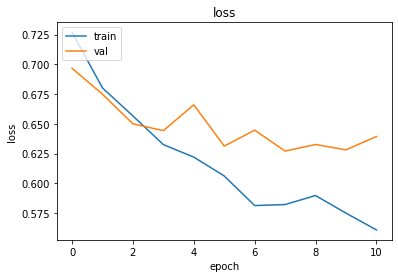

12835
Model: "model_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 37)]           0         
_________________________________________________________________
batch_normalization_370 (Bat (None, 2, 37)             148       
_________________________________________________________________
dropout_345 (Dropout)        (None, 2, 37)             0         
_________________________________________________________________
bidirectional_197 (Bidirecti (None, 2, 106)            38584     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 53)                33920     
_________________________________________________________________
dense2 (Dense)               (None, 32)                1728      
_________________________________________________________________
batch_normalization_371 (Bat (None, 32)            

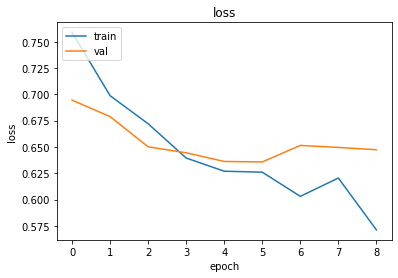

12835
Model: "model_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 37)]           0         
_________________________________________________________________
batch_normalization_372 (Bat (None, 2, 37)             148       
_________________________________________________________________
dropout_347 (Dropout)        (None, 2, 37)             0         
_________________________________________________________________
bidirectional_198 (Bidirecti (None, 2, 106)            38584     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 53)                33920     
_________________________________________________________________
dense2 (Dense)               (None, 32)                1728      
_________________________________________________________________
batch_normalization_373 (Bat (None, 32)            

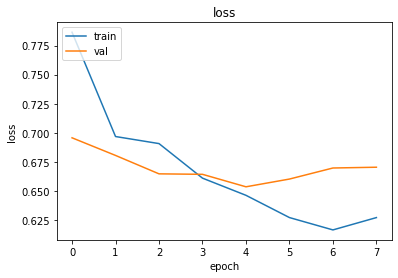

12834
avg_AUC :  0.7385277054858577
avg_AUC_2 :  0.7386078973468354


In [ ]:
#@title Default title text
print("\n ======= Select columns for LSTM ALL OBS.=========")

result = []

# First choose all varaibles
cols = v_perf + v_1+ v_2 + selected_comb
#df_fl = utils.shuffle(df_fl)
#cross_val(data, label, columns_fl, name,w) 
# n1 = 2*len(cols)
# n2 = len(cols)
label = 'label'
h = cross_val( df_fl, label, cols, 'lstm', 2)
    
best_auc = h[0]

# Next, remove one from the list each time



In [ ]:
best_auc

0.752735165519567


 ===========Test Litigious_3_dis============

error cols is here: ['Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p', 'aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue']
(53635, 113)
(38504, 2, 56) 337.0
Model: "model_55"
_____________________________________________________

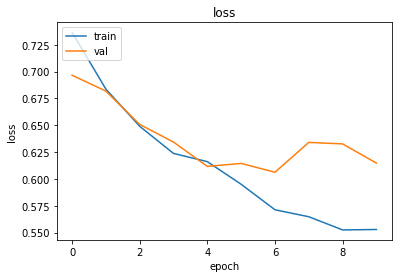

12835
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_112 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_87 (Dropout)         (None, 2, 56)             0         
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_113 (Bat (None, 32)             

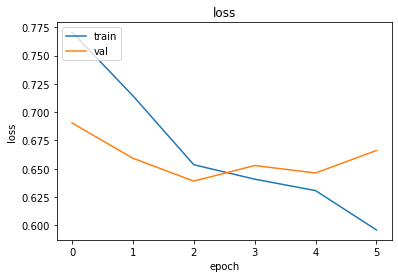

12835
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_89 (Dropout)         (None, 2, 56)             0         
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_115 (Bat (None, 32)             

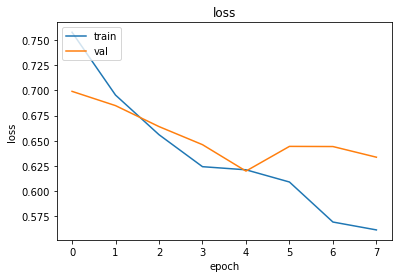

12834
avg_AUC :  0.7522027159978778
avg_AUC_2 :  0.7521288527925696
****** gap: -0.0005
current auc: 0.7522	best_auc: 0.7527	column: Litigious_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Achieve_3_p============

error cols is here: ['Litigious_3_dis', 'Positive_3_p', 'Compare_3_p', 

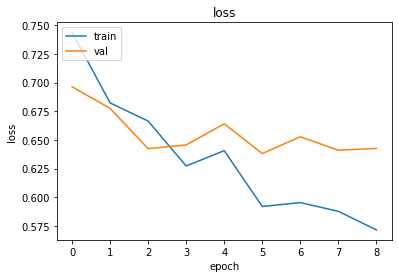

12835
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_118 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_93 (Dropout)         (None, 2, 56)             0         
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_119 (Bat (None, 32)             

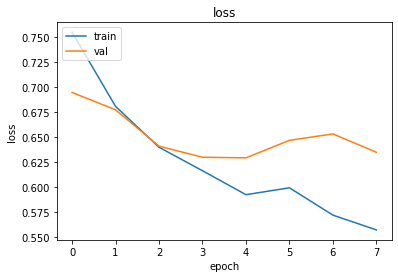

12835
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_120 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_95 (Dropout)         (None, 2, 56)             0         
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_121 (Bat (None, 32)             

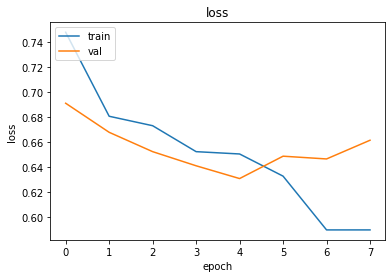

12834
avg_AUC :  0.7409982632064741
avg_AUC_2 :  0.7407636201883989
****** gap: -0.0117
current auc: 0.7410	best_auc: 0.7527	column: Achieve_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Positive_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Compare_3_p', 'Com

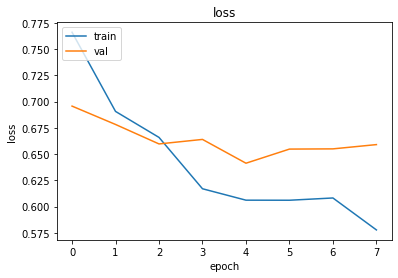

12835
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_124 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_99 (Dropout)         (None, 2, 56)             0         
_________________________________________________________________
bidirectional_74 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_125 (Bat (None, 32)             

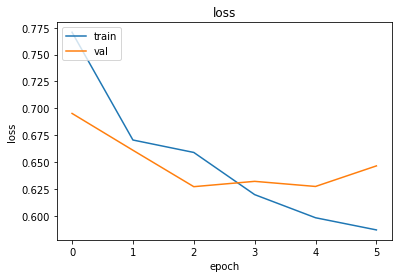

12835
Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_126 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_101 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_75 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_127 (Bat (None, 32)             

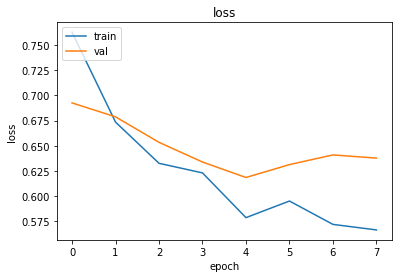

12834
avg_AUC :  0.7506099030192352
avg_AUC_2 :  0.7504602493540546
****** gap: -0.0021
current auc: 0.7506	best_auc: 0.7527	column: Positive_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Compare_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Co

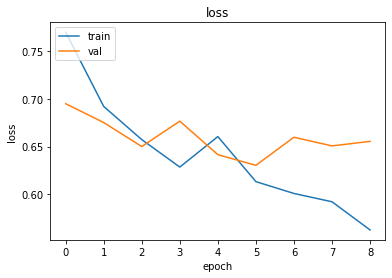

12835
Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_130 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_105 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_77 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_131 (Bat (None, 32)             

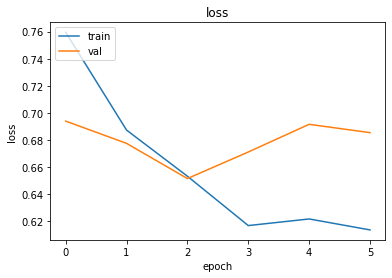

12835
Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_132 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_107 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_78 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_133 (Bat (None, 32)             

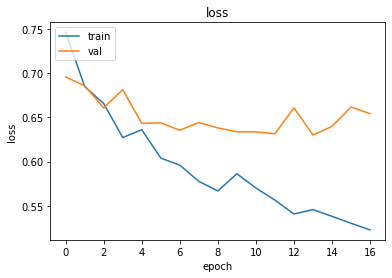

12834
avg_AUC :  0.7396819882476954
avg_AUC_2 :  0.7396551641573765
****** gap: -0.0131
current auc: 0.7397	best_auc: 0.7527	column: Compare_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Compare_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'C

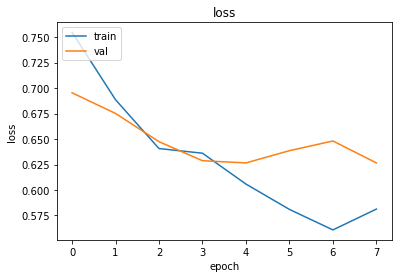

12835
Model: "model_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_111 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_80 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_137 (Bat (None, 32)             

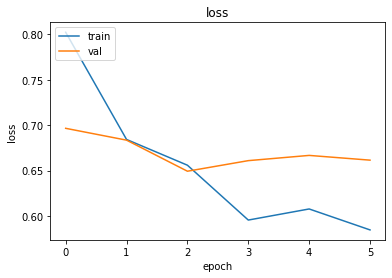

12835
Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_138 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_113 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_81 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_139 (Bat (None, 32)             

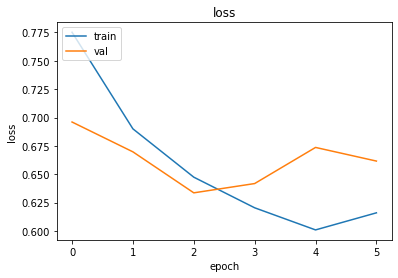

12834
avg_AUC :  0.7396953996621608
avg_AUC_2 :  0.739758520731972
****** gap: -0.0130
current auc: 0.7397	best_auc: 0.7527	column: Compare_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Achieve_3_n', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Achieve_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Co

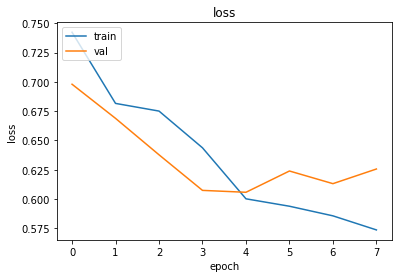

12835
Model: "model_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_142 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_117 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_83 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_143 (Bat (None, 32)             

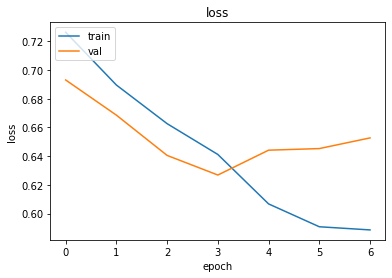

12835
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 56)]           0         
_________________________________________________________________
batch_normalization_144 (Bat (None, 2, 56)             224       
_________________________________________________________________
dropout_119 (Dropout)        (None, 2, 56)             0         
_________________________________________________________________
bidirectional_84 (Bidirectio (None, 2, 144)            74304     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 72)                62496     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2336      
_________________________________________________________________
batch_normalization_145 (Bat (None, 32)             

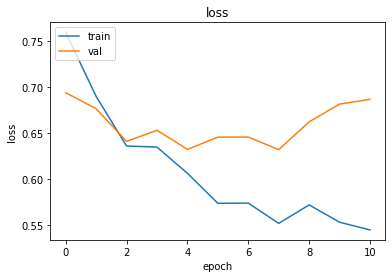

12834
avg_AUC :  0.7536536712166177
avg_AUC_2 :  0.7534615806186602
****** gap: 0.0009
*** Achieve_3_n removed ***
current auc: 0.7537	best_auc: 0.7537	column: Achieve_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Positive_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positi

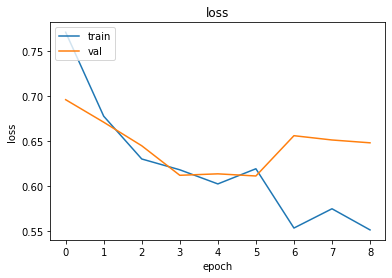

12835
Model: "model_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 55)]           0         
_________________________________________________________________
batch_normalization_148 (Bat (None, 2, 55)             220       
_________________________________________________________________
dropout_123 (Dropout)        (None, 2, 55)             0         
_________________________________________________________________
bidirectional_86 (Bidirectio (None, 2, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2304      
_________________________________________________________________
batch_normalization_149 (Bat (None, 32)             

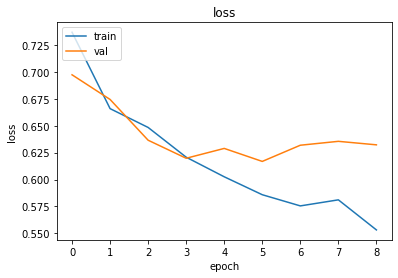

12835
Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 55)]           0         
_________________________________________________________________
batch_normalization_150 (Bat (None, 2, 55)             220       
_________________________________________________________________
dropout_125 (Dropout)        (None, 2, 55)             0         
_________________________________________________________________
bidirectional_87 (Bidirectio (None, 2, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2304      
_________________________________________________________________
batch_normalization_151 (Bat (None, 32)             

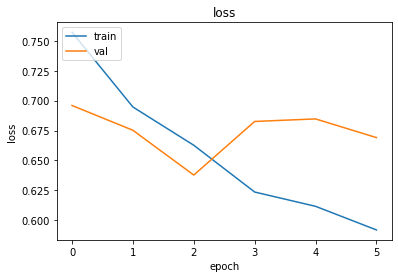

12834
avg_AUC :  0.746155878065437
avg_AUC_2 :  0.7458995241074887
****** gap: -0.0075
current auc: 0.7462	best_auc: 0.7537	column: Positive_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Uncertainty_3_new', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Uncertainty_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p'

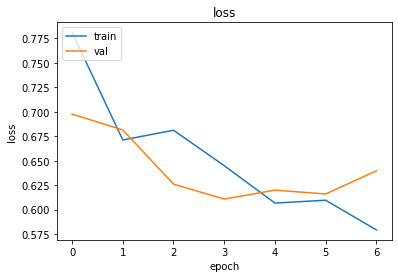

12835
Model: "model_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 55)]           0         
_________________________________________________________________
batch_normalization_154 (Bat (None, 2, 55)             220       
_________________________________________________________________
dropout_129 (Dropout)        (None, 2, 55)             0         
_________________________________________________________________
bidirectional_89 (Bidirectio (None, 2, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2304      
_________________________________________________________________
batch_normalization_155 (Bat (None, 32)             

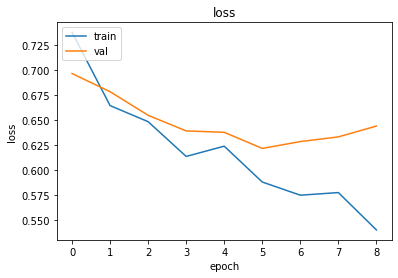

12835
Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 55)]           0         
_________________________________________________________________
batch_normalization_156 (Bat (None, 2, 55)             220       
_________________________________________________________________
dropout_131 (Dropout)        (None, 2, 55)             0         
_________________________________________________________________
bidirectional_90 (Bidirectio (None, 2, 142)            72136     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 71)                60776     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2304      
_________________________________________________________________
batch_normalization_157 (Bat (None, 32)             

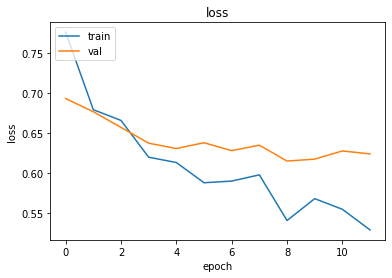

12834
avg_AUC :  0.7557146360085486
avg_AUC_2 :  0.7556937899858254
****** gap: 0.0021
*** Uncertainty_3_new removed ***
current auc: 0.7557	best_auc: 0.7557	column: Uncertainty_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Positive_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p'

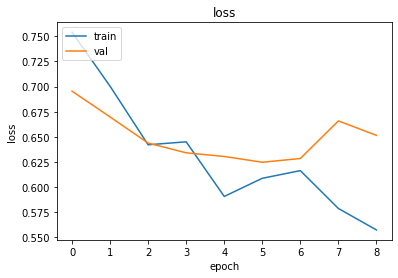

12835
Model: "model_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_160 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_135 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_92 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_161 (Bat (None, 32)             

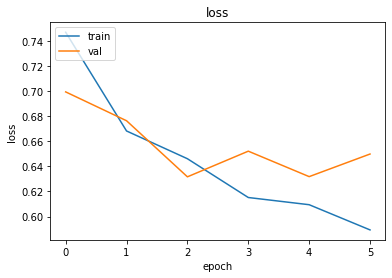

12835
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_162 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_137 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_93 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_163 (Bat (None, 32)             

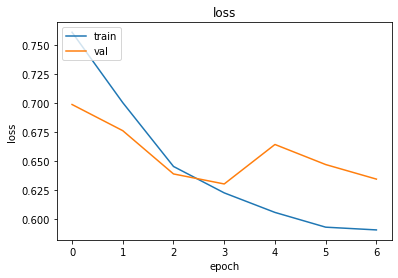

12834
avg_AUC :  0.7438180762859287
avg_AUC_2 :  0.743965678700192
****** gap: -0.0119
current auc: 0.7438	best_auc: 0.7557	column: Positive_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test StrongModal_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 

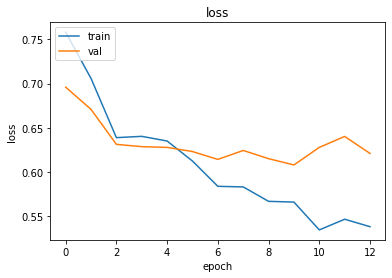

12835
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_166 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_141 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_95 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_167 (Bat (None, 32)             

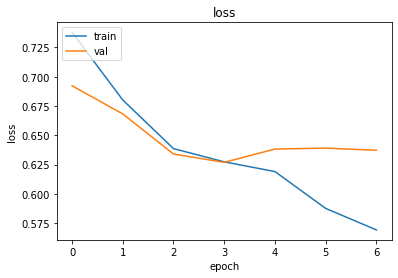

12835
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_168 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_143 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_96 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_169 (Bat (None, 32)             

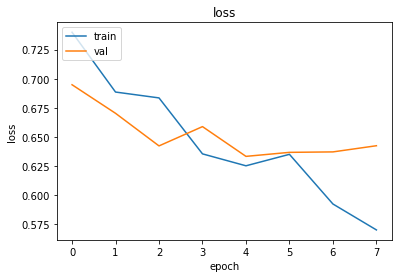

12834
avg_AUC :  0.7512157193630523
avg_AUC_2 :  0.7509590745210213
****** gap: -0.0045
current auc: 0.7512	best_auc: 0.7557	column: StrongModal_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Negative_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', '

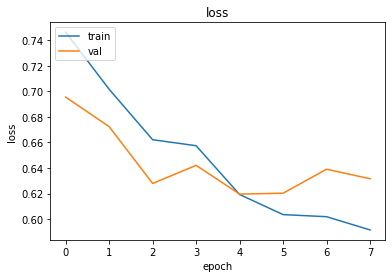

12835
Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_172 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_147 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_98 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_173 (Bat (None, 32)             

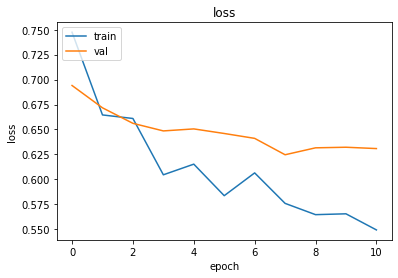

12835
Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_174 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_149 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_99 (Bidirectio (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_175 (Bat (None, 32)             

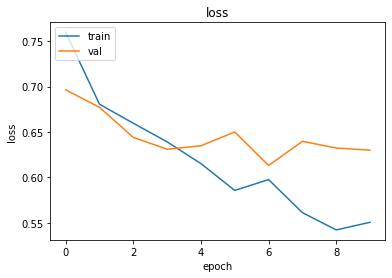

12834
avg_AUC :  0.7547198446277982
avg_AUC_2 :  0.7546607563200483
****** gap: -0.0010
current auc: 0.7547	best_auc: 0.7557	column: Negative_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Discrep_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positi

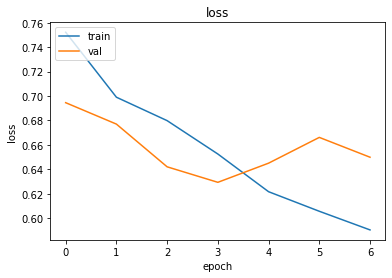

12835
Model: "model_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_178 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_153 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_101 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_179 (Bat (None, 32)             

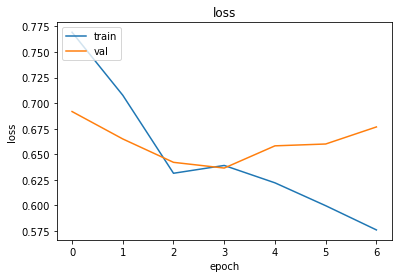

12835
Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_180 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_155 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_102 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_181 (Bat (None, 32)             

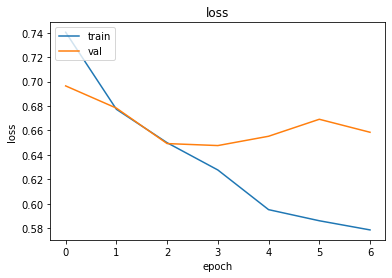

12834
avg_AUC :  0.7300080325653752
avg_AUC_2 :  0.7299727681364849
****** gap: -0.0257
current auc: 0.7300	best_auc: 0.7557	column: Discrep_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Uncertainty_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'P

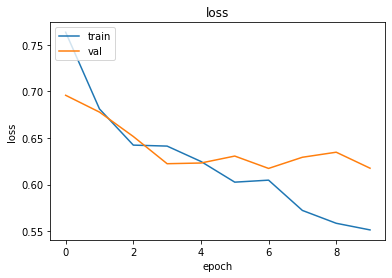

12835
Model: "model_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_184 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_159 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_104 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_185 (Bat (None, 32)             

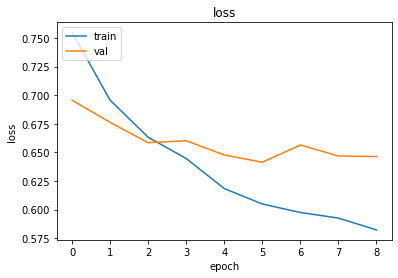

12835
Model: "model_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_186 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_161 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_105 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_187 (Bat (None, 32)             

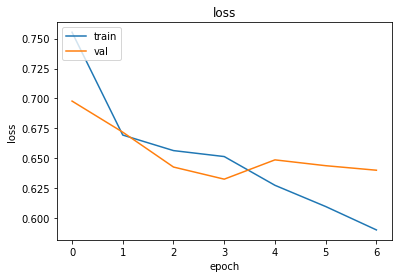

12834
avg_AUC :  0.7456061662389799
avg_AUC_2 :  0.7452599637334151
****** gap: -0.0101
current auc: 0.7456	best_auc: 0.7557	column: Uncertainty_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Reward_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', '

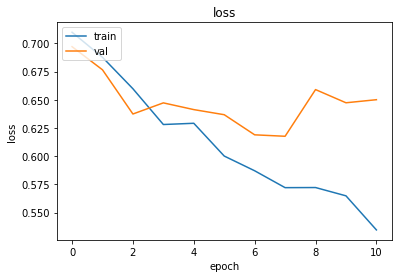

12835
Model: "model_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_190 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_165 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_107 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_191 (Bat (None, 32)             

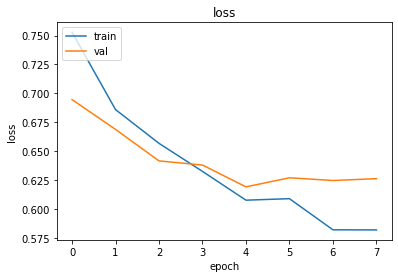

12835
Model: "model_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_192 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_167 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_108 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_193 (Bat (None, 32)             

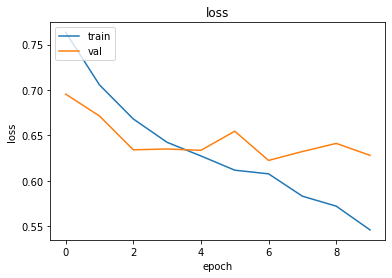

12834
avg_AUC :  0.7521430006190338
avg_AUC_2 :  0.752011529113299
****** gap: -0.0036
current auc: 0.7521	best_auc: 0.7557	column: Reward_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Reward_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positi

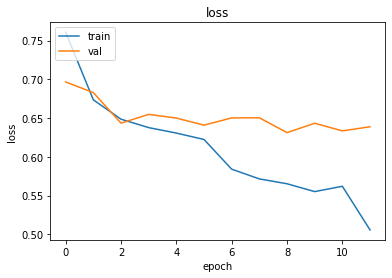

12835
Model: "model_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_196 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_171 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_110 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_197 (Bat (None, 32)             

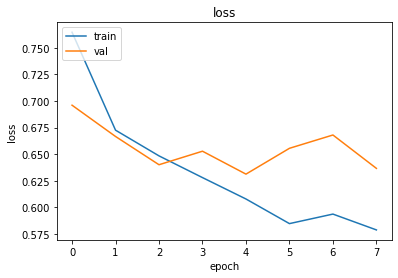

12835
Model: "model_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_198 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_173 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_111 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_199 (Bat (None, 32)             

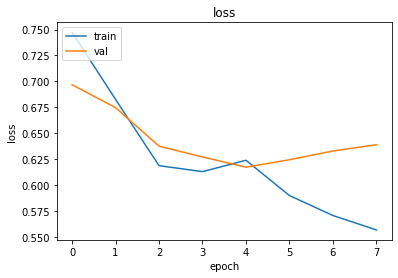

12834
avg_AUC :  0.7519112607932138
avg_AUC_2 :  0.7518215764897181
****** gap: -0.0038
current auc: 0.7519	best_auc: 0.7557	column: Reward_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Discrep_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Posi

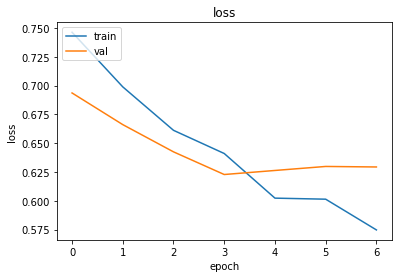

12835
Model: "model_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_202 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_177 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_113 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_203 (Bat (None, 32)            

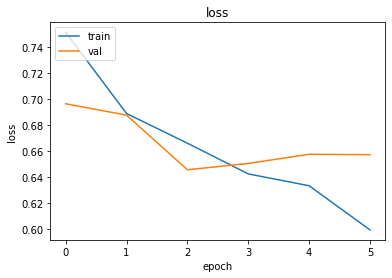

12835
Model: "model_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_179 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_114 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_205 (Bat (None, 32)            

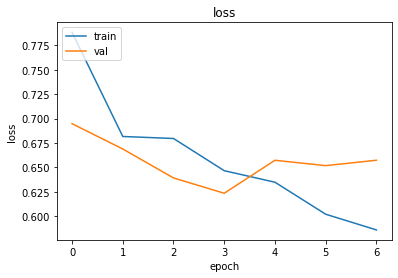

12834
avg_AUC :  0.7391373960329237
avg_AUC_2 :  0.7388619656318771
****** gap: -0.0166
current auc: 0.7391	best_auc: 0.7557	column: Discrep_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Litigious_3_new', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Litigious_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'P

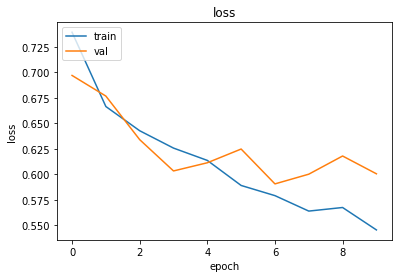

12835
Model: "model_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_208 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_183 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_116 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_209 (Bat (None, 32)            

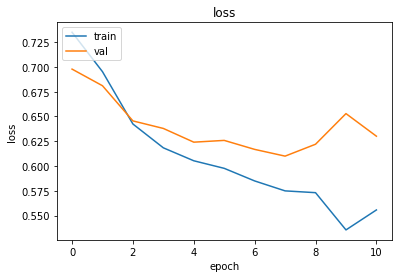

12835
Model: "model_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 54)]           0         
_________________________________________________________________
batch_normalization_210 (Bat (None, 2, 54)             216       
_________________________________________________________________
dropout_185 (Dropout)        (None, 2, 54)             0         
_________________________________________________________________
bidirectional_117 (Bidirecti (None, 2, 140)            70000     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 70)                59080     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2272      
_________________________________________________________________
batch_normalization_211 (Bat (None, 32)            

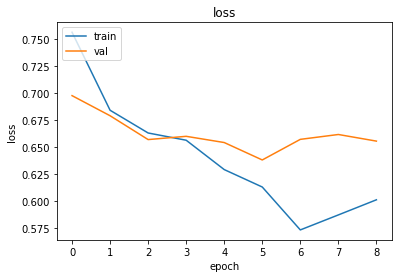

12834
avg_AUC :  0.7629767848109669
avg_AUC_2 :  0.7630293133611719
****** gap: 0.0073
*** Litigious_3_new removed ***
current auc: 0.7630	best_auc: 0.7630	column: Litigious_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Reward_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3

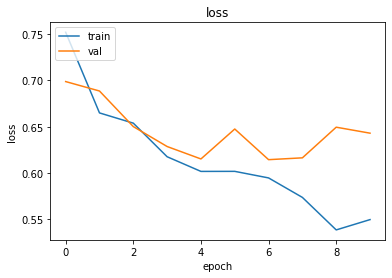

12835
Model: "model_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_214 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_189 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_119 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_215 (Bat (None, 32)            

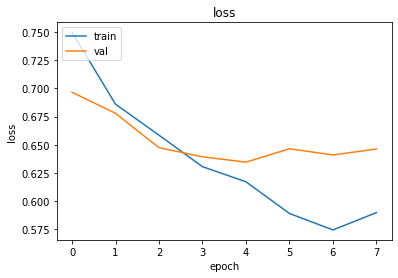

12835
Model: "model_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_216 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_191 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_120 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_217 (Bat (None, 32)            

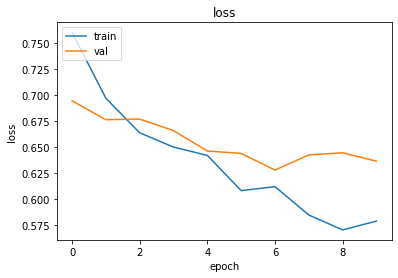

12834
avg_AUC :  0.7476327941831694
avg_AUC_2 :  0.7476093637598062
****** gap: -0.0153
current auc: 0.7476	best_auc: 0.7630	column: Reward_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Negative_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3

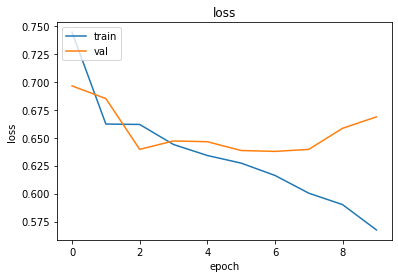

12835
Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_220 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_195 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_122 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_221 (Bat (None, 32)            

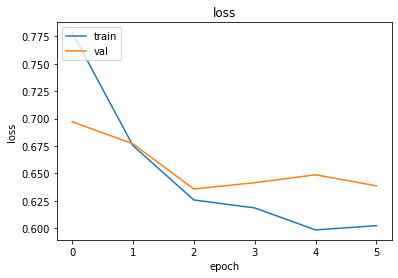

12835
Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_222 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_197 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_123 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_223 (Bat (None, 32)            

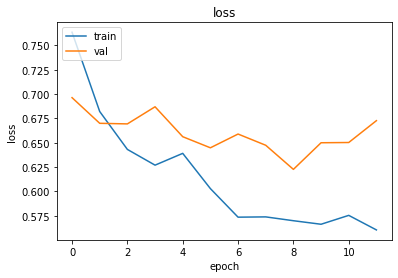

12834
avg_AUC :  0.7507273657173416
avg_AUC_2 :  0.7504324481647491
****** gap: -0.0122
current auc: 0.7507	best_auc: 0.7630	column: Negative_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test StrongModal_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Pos

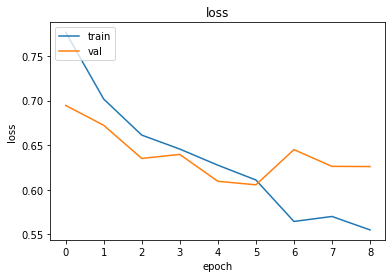

12835
Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_226 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_201 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_125 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_227 (Bat (None, 32)            

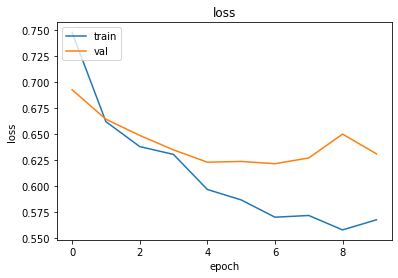

12835
Model: "model_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_228 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_203 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_126 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_229 (Bat (None, 32)            

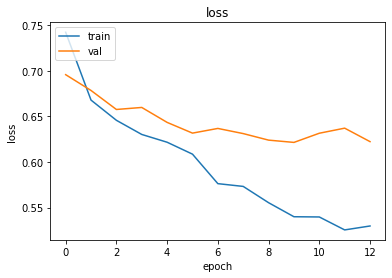

12834
avg_AUC :  0.7612754738693752
avg_AUC_2 :  0.7610342787333937
****** gap: -0.0017
current auc: 0.7613	best_auc: 0.7630	column: StrongModal_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Uncertainty_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', '

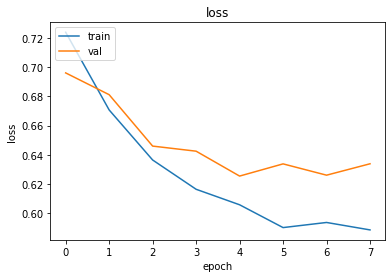

12835
Model: "model_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_232 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_207 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_128 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_233 (Bat (None, 32)            

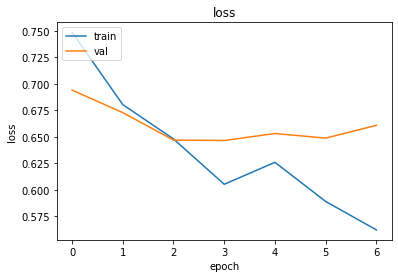

12835
Model: "model_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_234 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_209 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_129 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_235 (Bat (None, 32)            

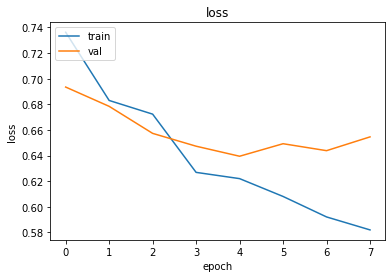

12834
avg_AUC :  0.736318303842534
avg_AUC_2 :  0.7363843342825642
****** gap: -0.0267
current auc: 0.7363	best_auc: 0.7630	column: Uncertainty_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Discrep_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posit

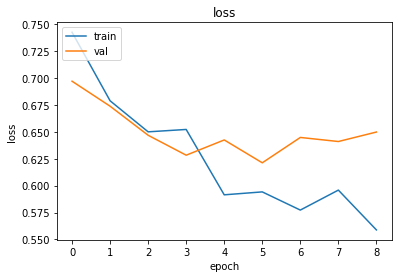

12835
Model: "model_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_238 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_213 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_131 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_239 (Bat (None, 32)            

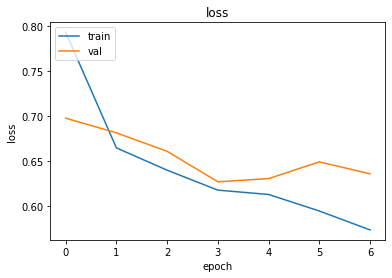

12835
Model: "model_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_240 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_215 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_132 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_241 (Bat (None, 32)            

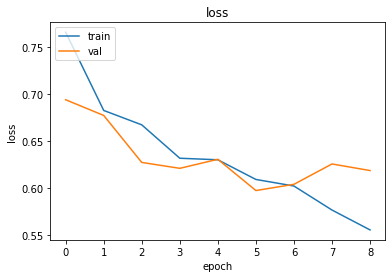

12834
avg_AUC :  0.7574136246705027
avg_AUC_2 :  0.7572849757584271
****** gap: -0.0056
current auc: 0.7574	best_auc: 0.7630	column: Discrep_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Litigious_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positi

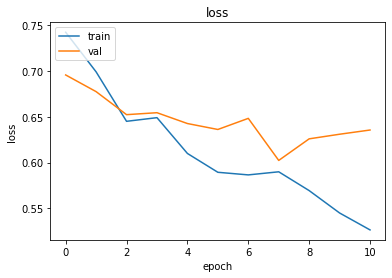

12835
Model: "model_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_244 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_219 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_134 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_245 (Bat (None, 32)            

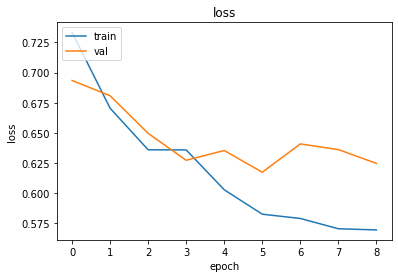

12835
Model: "model_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_246 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_221 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_135 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_247 (Bat (None, 32)            

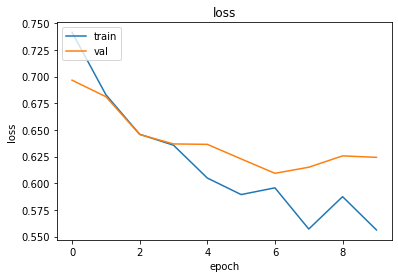

12834
avg_AUC :  0.7620170007985191
avg_AUC_2 :  0.761894386341289
****** gap: -0.0010
current auc: 0.7620	best_auc: 0.7630	column: Litigious_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Positive_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positi

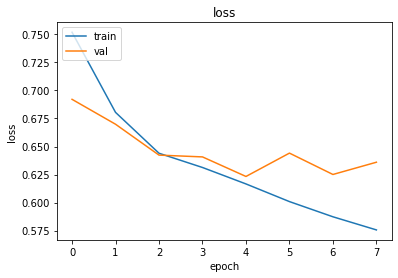

12835
Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_250 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_225 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_137 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_251 (Bat (None, 32)            

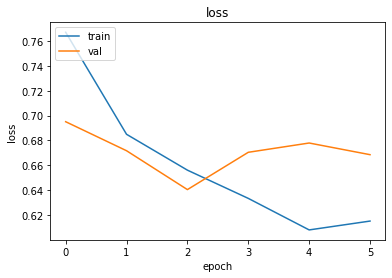

12835
Model: "model_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_252 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_227 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_138 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_253 (Bat (None, 32)            

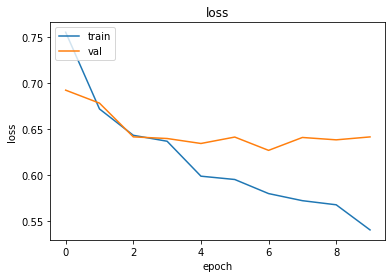

12834
avg_AUC :  0.7399703019670084
avg_AUC_2 :  0.7398471120816253
****** gap: -0.0230
current auc: 0.7400	best_auc: 0.7630	column: Positive_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Negative_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posi

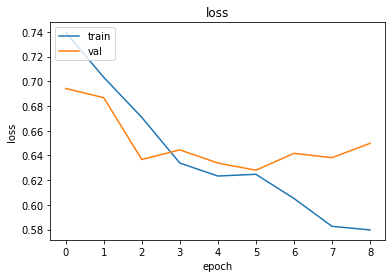

12835
Model: "model_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_256 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_231 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_140 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_257 (Bat (None, 32)            

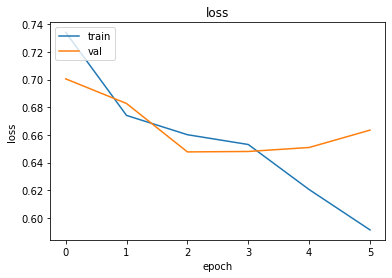

12835
Model: "model_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_258 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_233 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_141 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_259 (Bat (None, 32)            

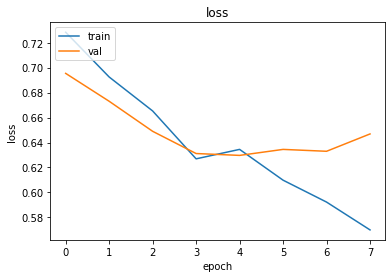

12834
avg_AUC :  0.7408451688336379
avg_AUC_2 :  0.7407003026472052
****** gap: -0.0221
current auc: 0.7408	best_auc: 0.7630	column: Negative_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Compare_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positiv

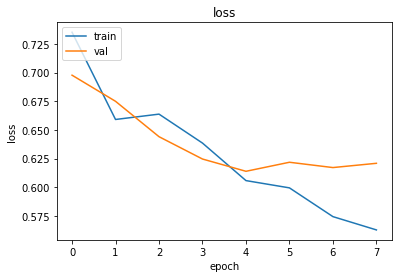

12835
Model: "model_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_262 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_237 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_143 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_263 (Bat (None, 32)            

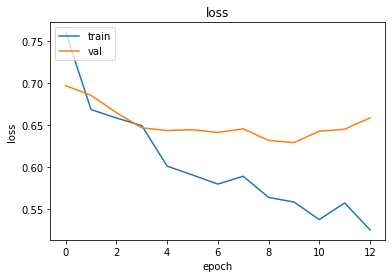

12835
Model: "model_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_264 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_239 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_144 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_265 (Bat (None, 32)            

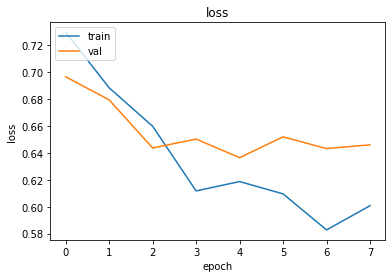

12834
avg_AUC :  0.7476072892448887
avg_AUC_2 :  0.747732806361125
****** gap: -0.0154
current auc: 0.7476	best_auc: 0.7630	column: Compare_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Litigious_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_

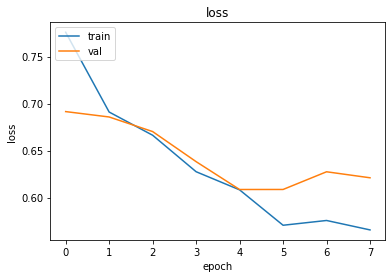

12835
Model: "model_134"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_268 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_243 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_146 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_269 (Bat (None, 32)            

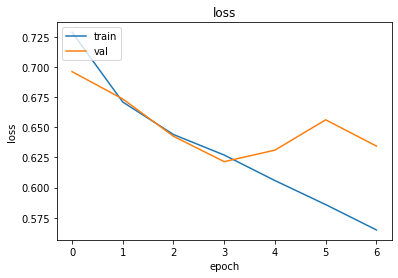

12835
Model: "model_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_270 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_245 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_147 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_271 (Bat (None, 32)            

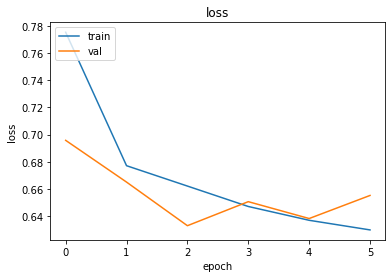

12834
avg_AUC :  0.7515490543230947
avg_AUC_2 :  0.7515978367748278
****** gap: -0.0114
current auc: 0.7515	best_auc: 0.7630	column: Litigious_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test WeakModal_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posi

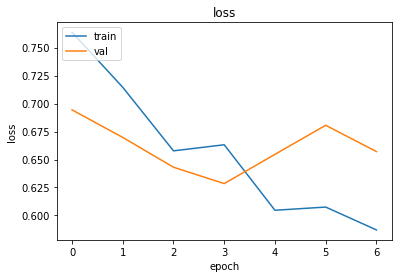

12835
Model: "model_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_274 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_249 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_149 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_275 (Bat (None, 32)            

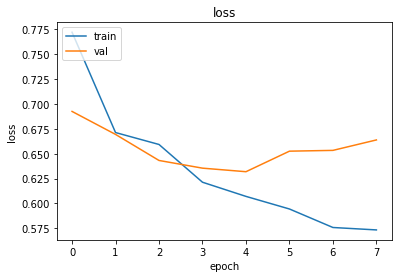

12835
Model: "model_138"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_276 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_251 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_150 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_277 (Bat (None, 32)            

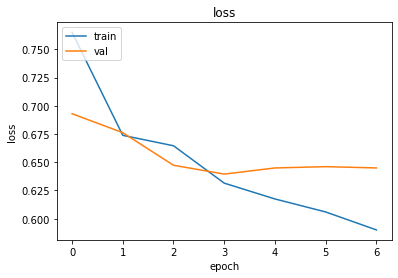

12834
avg_AUC :  0.7360117188352673
avg_AUC_2 :  0.736002566754779
****** gap: -0.0270
current auc: 0.7360	best_auc: 0.7630	column: WeakModal_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test cr3============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new'

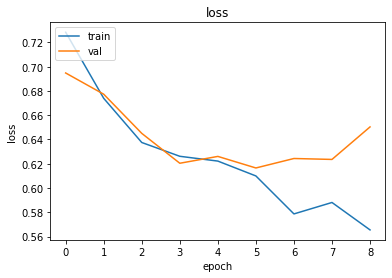

12835
Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_280 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_255 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_152 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_281 (Bat (None, 32)            

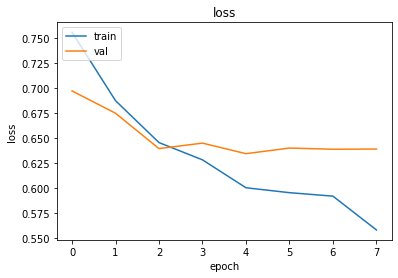

12835
Model: "model_141"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_282 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_257 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_153 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_283 (Bat (None, 32)            

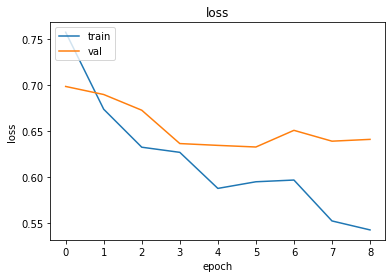

12834
avg_AUC :  0.7457499705585291
avg_AUC_2 :  0.7458393990473636
****** gap: -0.0172
current auc: 0.7457	best_auc: 0.7630	column: cr3
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Discrep_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', '

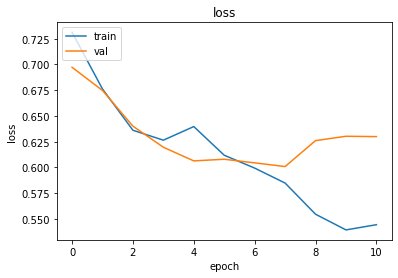

12835
Model: "model_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_286 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_261 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_155 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_287 (Bat (None, 32)            

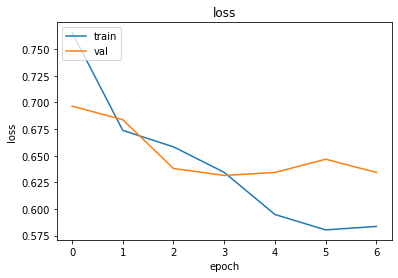

12835
Model: "model_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_288 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_263 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_156 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_289 (Bat (None, 32)            

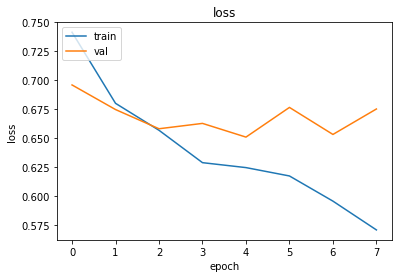

12834
avg_AUC :  0.7437467856583124
avg_AUC_2 :  0.7437456635465485
****** gap: -0.0192
current auc: 0.7437	best_auc: 0.7630	column: Discrep_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Achieve_3_dis============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive

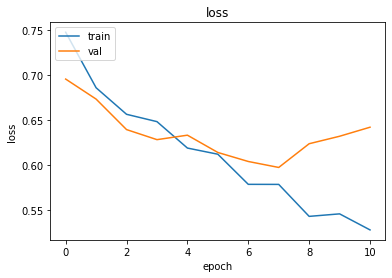

12835
Model: "model_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_292 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_267 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_158 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_293 (Bat (None, 32)            

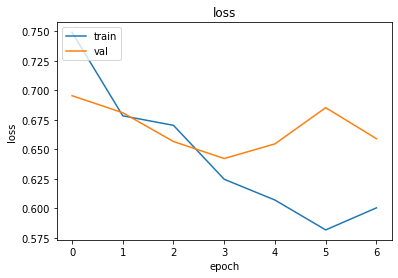

12835
Model: "model_147"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_294 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_269 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_159 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_295 (Bat (None, 32)            

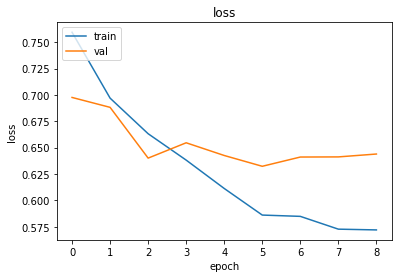

12834
avg_AUC :  0.7461168789130562
avg_AUC_2 :  0.7459665662099291
****** gap: -0.0169
current auc: 0.7461	best_auc: 0.7630	column: Achieve_3_dis
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Compare_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positi

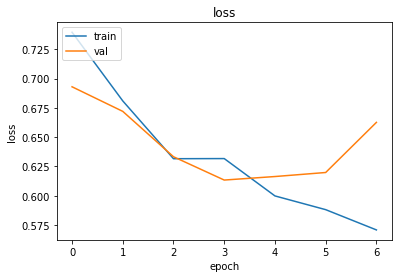

12835
Model: "model_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_298 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_273 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_161 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_299 (Bat (None, 32)            

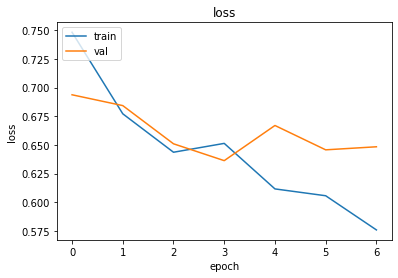

12835
Model: "model_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_300 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_275 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_162 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_301 (Bat (None, 32)            

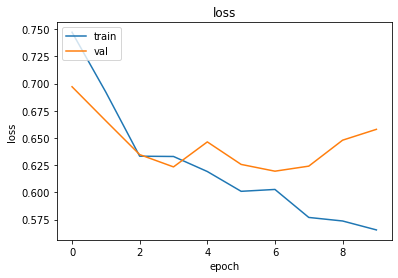

12834
avg_AUC :  0.7507662066191534
avg_AUC_2 :  0.7503922761113027
****** gap: -0.0122
current auc: 0.7508	best_auc: 0.7630	column: Compare_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Uncertainty_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posi

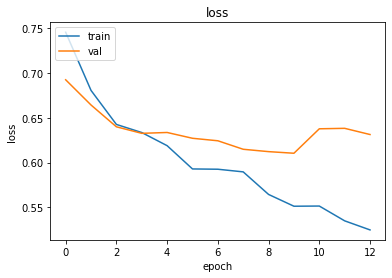

12835
Model: "model_152"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_304 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_279 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_164 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_305 (Bat (None, 32)            

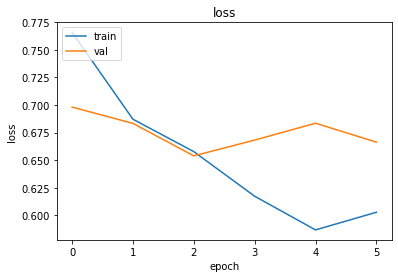

12835
Model: "model_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_306 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_281 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_165 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_307 (Bat (None, 32)            

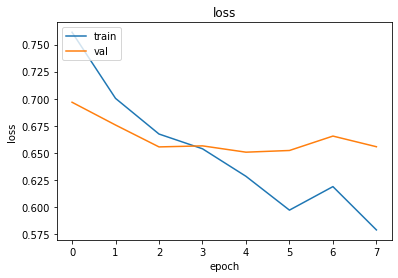

12834
avg_AUC :  0.7363052294651963
avg_AUC_2 :  0.736350015111077
****** gap: -0.0267
current auc: 0.7363	best_auc: 0.7630	column: Uncertainty_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Achieve_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posit

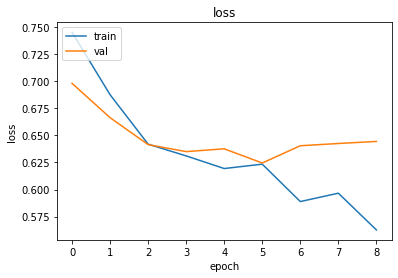

12835
Model: "model_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_310 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_285 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_167 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_311 (Bat (None, 32)            

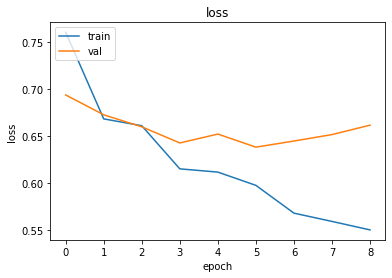

12835
Model: "model_156"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_312 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_287 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_168 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_313 (Bat (None, 32)            

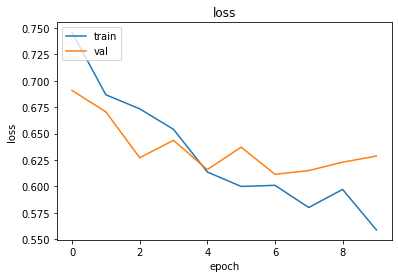

12834
avg_AUC :  0.7525245372498336
avg_AUC_2 :  0.7523587114295078
****** gap: -0.0105
current auc: 0.7525	best_auc: 0.7630	column: Achieve_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test StrongModal_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posi

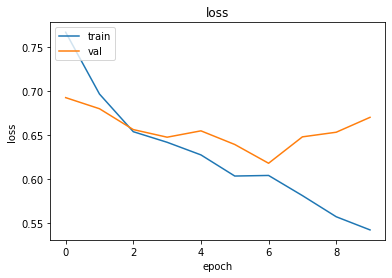

12835
Model: "model_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_316 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_291 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_170 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_317 (Bat (None, 32)            

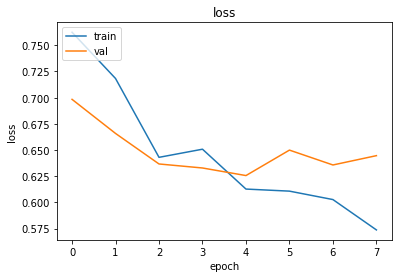

12835
Model: "model_159"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_318 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_293 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_171 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_319 (Bat (None, 32)            

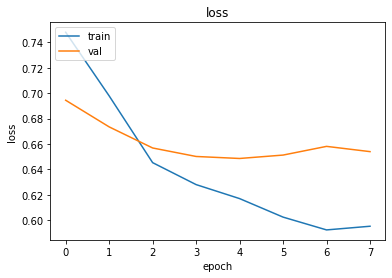

12834
avg_AUC :  0.7464695796774644
avg_AUC_2 :  0.7462506970250332
****** gap: -0.0165
current auc: 0.7465	best_auc: 0.7630	column: StrongModal_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test WeakModal_3_n============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posi

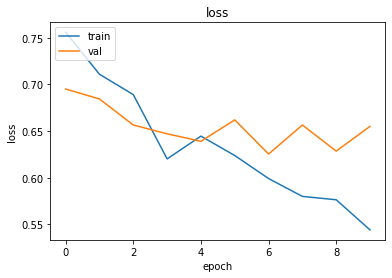

12835
Model: "model_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_322 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_297 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_173 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_323 (Bat (None, 32)            

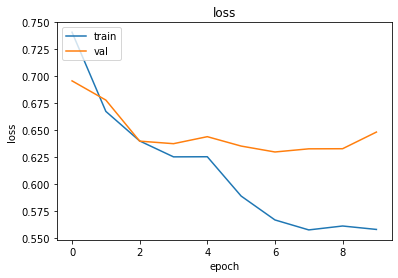

12835
Model: "model_162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_324 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_299 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_174 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_325 (Bat (None, 32)            

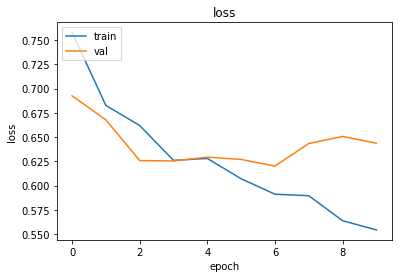

12834
avg_AUC :  0.7529014663597055
avg_AUC_2 :  0.7528253457456996
****** gap: -0.0101
current auc: 0.7529	best_auc: 0.7630	column: WeakModal_3_n
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test pastavg3============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_

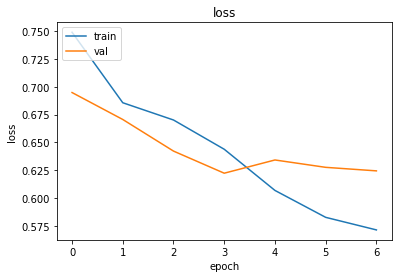

12835
Model: "model_164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_328 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_303 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_176 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_329 (Bat (None, 32)            

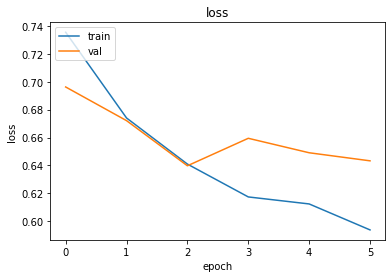

12835
Model: "model_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_330 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_305 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_177 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_331 (Bat (None, 32)            

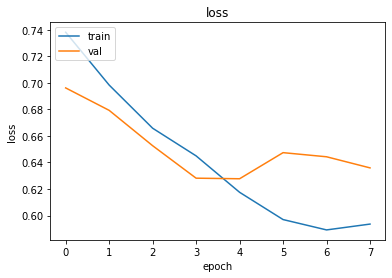

12834
avg_AUC :  0.7435292864450619
avg_AUC_2 :  0.7436717044017929
****** gap: -0.0194
current auc: 0.7435	best_auc: 0.7630	column: pastavg3
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Negative_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3

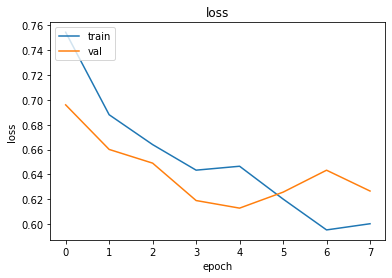

12835
Model: "model_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_334 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_309 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_179 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_335 (Bat (None, 32)            

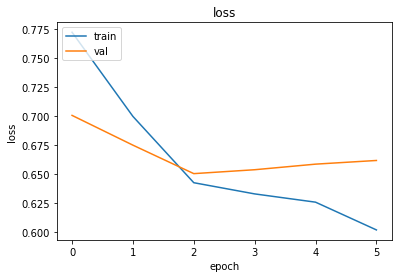

12835
Model: "model_168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_336 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_311 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_180 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_337 (Bat (None, 32)            

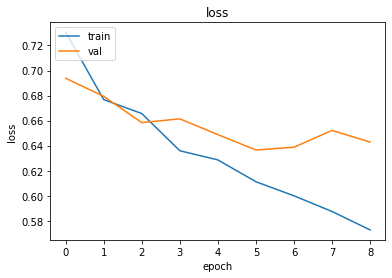

12834
avg_AUC :  0.74054314808716
avg_AUC_2 :  0.7402147794846909
****** gap: -0.0224
current auc: 0.7405	best_auc: 0.7630	column: Negative_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test s1============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', '

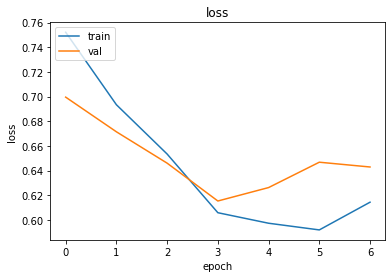

12835
Model: "model_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_340 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_315 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_182 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_341 (Bat (None, 32)            

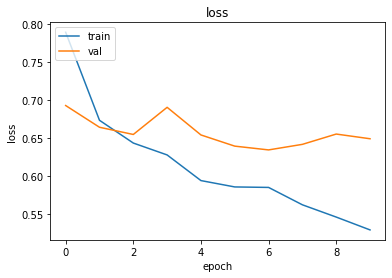

12835
Model: "model_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_342 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_317 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_183 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_343 (Bat (None, 32)            

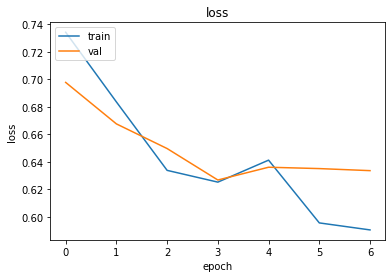

12834
avg_AUC :  0.7472723045599977
avg_AUC_2 :  0.7470719627799274
****** gap: -0.0157
current auc: 0.7473	best_auc: 0.7630	column: s1
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test WeakModal_3_new============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new'

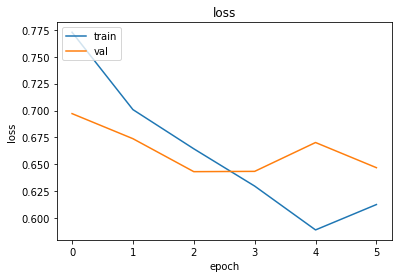

12835
Model: "model_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_346 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_321 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_185 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_347 (Bat (None, 32)            

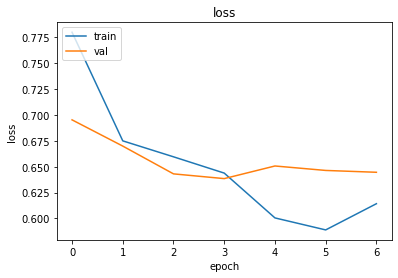

12835
Model: "model_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_348 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_323 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_186 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_349 (Bat (None, 32)            

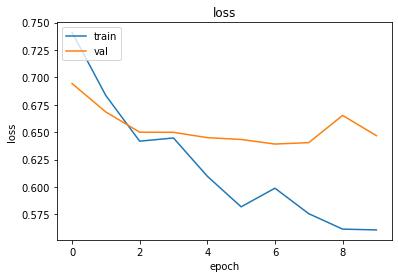

12834
avg_AUC :  0.7359605993232656
avg_AUC_2 :  0.735795587565499
****** gap: -0.0270
current auc: 0.7360	best_auc: 0.7630	column: WeakModal_3_new
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test WeakModal_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Posit

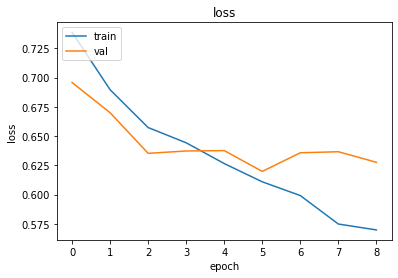

12835
Model: "model_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_352 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_327 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_188 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_353 (Bat (None, 32)            

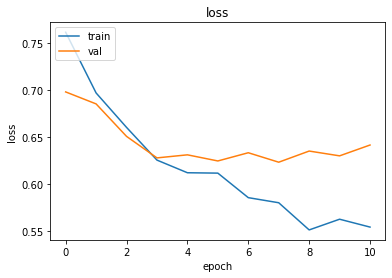

12835
Model: "model_177"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_354 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_329 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_189 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_355 (Bat (None, 32)            

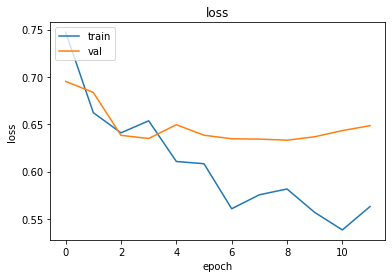

12834
avg_AUC :  0.7540299544556088
avg_AUC_2 :  0.7539976513980938
****** gap: -0.0089
current auc: 0.7540	best_auc: 0.7630	column: WeakModal_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test Reward_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_

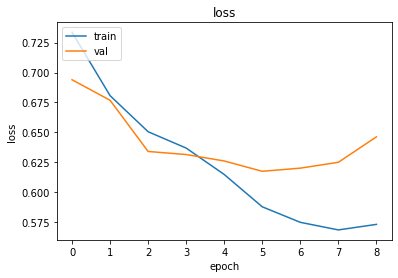

12835
Model: "model_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_358 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_333 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_191 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_359 (Bat (None, 32)            

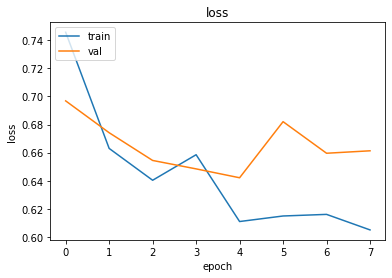

12835
Model: "model_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_360 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_335 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_192 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_361 (Bat (None, 32)            

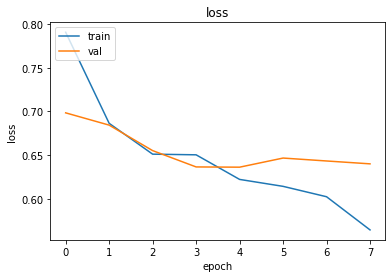

12834
avg_AUC :  0.7420346046084508
avg_AUC_2 :  0.742188796945434
****** gap: -0.0209
current auc: 0.7420	best_auc: 0.7630	column: Reward_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']

 ===========Test StrongModal_3_p============

error cols is here: ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive

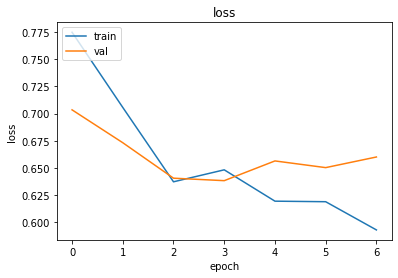

12835
Model: "model_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_364 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_339 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_194 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_365 (Bat (None, 32)            

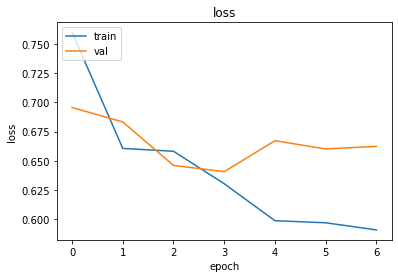

12835
Model: "model_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 53)]           0         
_________________________________________________________________
batch_normalization_366 (Bat (None, 2, 53)             212       
_________________________________________________________________
dropout_341 (Dropout)        (None, 2, 53)             0         
_________________________________________________________________
bidirectional_195 (Bidirecti (None, 2, 138)            67896     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 69)                57408     
_________________________________________________________________
dense2 (Dense)               (None, 32)                2240      
_________________________________________________________________
batch_normalization_367 (Bat (None, 32)            

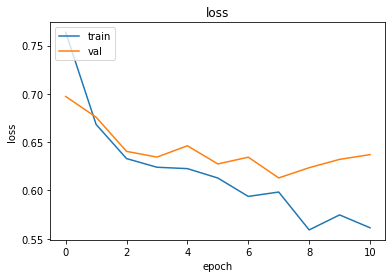

12834
avg_AUC :  0.7426314132097552
avg_AUC_2 :  0.7425439604643145
****** gap: -0.0203
current auc: 0.7426	best_auc: 0.7630	column: StrongModal_3_p
selected columns:  ['Litigious_3_dis', 'Achieve_3_p', 'Positive_3_p', 'Compare_3_p', 'Compare_3_dis', 'Positive_3_n', 'Positive_3_new', 'StrongModal_3_dis', 'Negative_3_p', 'Discrep_3_n', 'Uncertainty_3_dis', 'Reward_3_dis', 'Reward_3_new', 'Discrep_3_dis', 'Reward_3_n', 'Negative_3_n', 'StrongModal_3_new', 'Uncertainty_3_p', 'Discrep_3_new', 'Litigious_3_p', 'Positive_3_dis', 'Negative_3_dis', 'Compare_3_n', 'Litigious_3_n', 'WeakModal_3_dis', 'cr3', 'Discrep_3_p', 'Achieve_3_dis', 'Compare_3_new', 'Uncertainty_3_n', 'Achieve_3_new', 'StrongModal_3_n', 'WeakModal_3_n', 'pastavg3', 'Negative_3_new', 's1', 'WeakModal_3_new', 'WeakModal_3_p', 'Reward_3_p', 'StrongModal_3_p']


In [ ]:

#all_cols = selected_new_all

selected_cols = selected_new_all + v_1 + v_2
random.shuffle(selected_cols)

for col in selected_cols:
    
    print("\n ===========Test {}============\n".format(col))
    
    test_cols = [item for item in selected_cols if item !=col]
    #test_cols = v_perf + v_1+ v_2 + [col]
    
    # n1 = 2*len(test_cols)
    # n2 = len(test_cols)
    label = 'label'
    h = cross_val( df_fl, label, test_cols + v_perf, 'lstm_wds', 2)

    gap = h[0] - best_auc
    print('****** gap: {0:.4f}'.format(gap))
    
    result.append([col, h[0], best_auc, gap]) #gap
    
    if h[0]>= best_auc:  # better to drop col
        
        selected_cols = test_cols
        
        best_auc = h[0]
        
        print("*** {} removed ***".format(col))
    
    print("current auc: {0:.4f}\tbest_auc: {1:.4f}\tcolumn: {2}".format(h[0], best_auc, col))
    print("selected columns: ", selected_cols)


pd.DataFrame(result, columns = ["column", "auc", "prev_auc","gap"]).to_csv("var_selection_lstm_bi_2.csv")   

In [ ]:
print(random.shuffle(selected_new_all))

In [ ]:
'Litigious_3_dis' in list(df_fl.columns)

True